# Cost-Benefit Analysis on Mosquito Spraying

## Import Libraries

In [20]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
pip install geopy

## Import Data

In [12]:
spray = pd.read_csv('./Data/spray.csv')
train = pd.read_csv('./Data/train.csv')
weather = pd.read_csv('./Data/weather.csv')
pd.options.display.max_columns = None

## Data Cleaning

In [ ]:
# Remove [Time] columns and remove duplicated rows
spray.drop(columns=["Time"], inplace=True)
spray.drop_duplicates(inplace=True)

In [ ]:
#Format the Train dataset to include only 2011 and 2013 where we have the spraying data
train["Year"] = [x[:4] for x in train['Date']]
train["Year"] = train.Year.astype(int)
train = train[(train["Year"] == 2011) | (train["Year"] == 2013)]
train.drop(columns="Year", inplace=True)

In [ ]:
# Remove the 50 NumMosquitos limit and group the rows together to calculate the total number of mosquitos at each Trap
cols = list(train.drop(columns=["NumMosquitos"]).columns)
train = pd.DataFrame(train.groupby(cols)["NumMosquitos"].agg('sum'))
train = train.reset_index()
train.info()

In [ ]:
#Convert datatype for Date column
train["Date"] = pd.to_datetime(train["Date"])
spray["Date"] = pd.to_datetime(spray["Date"])

#Assumes a 14-day effectiveness period for spraying
spray["Effective_Till"] = spray["Date"] + pd.to_timedelta(6, unit='d')
spray["7_Days_Prior"] = spray["Date"] + pd.to_timedelta(-6, unit='d')

## Feature Engineering

In [ ]:
# Creates time group for the spraying
list(enumerate(set(spray["Date"])))
dict = {k:v for (v,k) in list(enumerate(set(spray["Date"]), 1))}
spray['Time_Group'] = spray['Date'].map(dict)
groups = spray.drop(columns={"Latitude", "Longitude"})
groups.drop_duplicates(inplace=True)
groups

In [ ]:
# Drop row index 9881 as we group it together with index 7213 which is just a day earlier
groups.drop(9881, inplace=True)

In [ ]:
# Maps time group to the train data

train["Time_Group"] = 0
train["Sprayed_Date"] = 0
for i, row1 in train.iterrows():
    for j, row2 in groups.iterrows():
        if train.loc[i, "Date"] >= groups.loc[j, "Date"]:
                if train.loc[i, "Date"] <= groups.loc[j, "Effective_Till"]:
                    train.loc[i, "Time_Group"] = "after"
                    train.loc[i, "Sprayed_Date"] = groups.loc[j, "Date"]
        elif train.loc[i, "Date"] < groups.loc[j, "Date"]:
                if train.loc[i, "Date"] >= groups.loc[j, "7_Days_Prior"]:
                    train.loc[i, "Time_Group"] = "before"
                    train.loc[i, "Sprayed_Date"] = groups.loc[j, "Date"]

In [ ]:
# Find the minimum distance each trap is from the nearest sprayed location for each particular spray date

import geopy.distance as gp

train["sprayed_displacement"] = 0.0

for i, row1 in train.iterrows():
    if train.Time_Group[i] != 0:
        dist = []
        coord1 = (train.Latitude[i],train.Longitude[i])
        for j, row2 in spray.iterrows():
            coord2 = (spray.Latitude[j],spray.Longitude[j])
            dist.append(gp.distance(coord1, coord2).km)
        train.sprayed_displacement[i] = min(dist)

In [ ]:
## Normalize spray strength to between 0 and 1
train["sprayed_strength"] = 0.0
for i, row1 in train.iterrows():
    if train.Time_Group[i] != 0:
        train.sprayed_strength[i] = 1/(1+ train.sprayed_displacement[i])

## Backup and Save the information to CSV

In [ ]:
train.to_csv('./Data/spray_train.csv')

## Import the information from CSV

In [95]:
train = pd.read_csv('./Data/spray_train.csv')

In [96]:
train = train.reset_index(drop=True).drop(columns="Unnamed: 0")

In [98]:
df = train
cols = list(df.drop(columns=["NumMosquitos", "Species" ]).columns)
df = pd.DataFrame(df.groupby(cols)["NumMosquitos"].agg('sum'))
df = df.reset_index()

## Quick and Dirty Method to Check for Reduction in Mosquito Count using Mean

In [111]:
# Quick and dirty method to check for reduction in mean after spraying (compare the mean before and after spraying)
counter = 0
traps = list(set(df[df["sprayed_strength"] >=0.25]["Trap"]))
for i in traps:
    df2 = df[(df['Trap'] == i) & (df['Date'] > '2011-12-30 04:00:00')]
    sample1 = df2[df2["Time_Group"] == "before"]["NumMosquitos"]
    sample2 = df2[df2["Time_Group"] == "after"]["NumMosquitos"]
    if np.mean(sample1) > np.mean(sample2): #Mean decreased after spraying
        counter += 1
print(counter/len(traps))
print(counter)
print(len(traps))

0.625
35
56


## One Tail T-Test to check for Reduction in Mosquito Count

In [108]:
# Compute the p-value for a reduction in mean number of mosquitoes after spray using one-tail t-test
p_values = {}
traps = list(set(df[df["sprayed_strength"] >=0.25]["Trap"]))
for i in traps:
    df2 = df[(df['Trap'] == i) & (df['Date'] > '2011-12-30 04:00:00')]
    sample1 = df2[df2["Time_Group"] == "before"]["NumMosquitos"]
    sample2 = df2[df2["Time_Group"] == "after"]["NumMosquitos"]
    if np.mean(sample1) > np.mean(sample2): #Mean decreased after spraying
        p_values.update({i : stats.ttest_ind(sample1,sample2, equal_var = False).pvalue/2})
p_values

ttest = pd.DataFrame.from_dict(p_values, orient="index").sort_values(by=0, ascending=True).rename(columns={0:"p_value"})
#print("% locations that exhibited statistical significance in spraying: ",len(ttest[ttest["p_value"] <= 0.05])/len(ttest["p_value"]))

In [109]:
# Check number of traps with a reduction in mean after spraying
len(ttest["p_value"])

35

In [110]:
# Find the traps with a p-value below or equals to 5%
(ttest[ttest["p_value"] <= 0.05])

,p_value
T089,0.001085
T012,0.007030
T099,0.007865
T228,0.009371
T061,0.037890


## Analysis on Trap T228

In [90]:
df = train[train['Trap'] == "T228"]

In [91]:
cols = list(df.drop(columns=["NumMosquitos", "Species" ]).columns)
df = pd.DataFrame(df.groupby(cols)["NumMosquitos"].agg('sum'))
df = df.reset_index()

Text(0.5, 1.0, 'Trap T228')

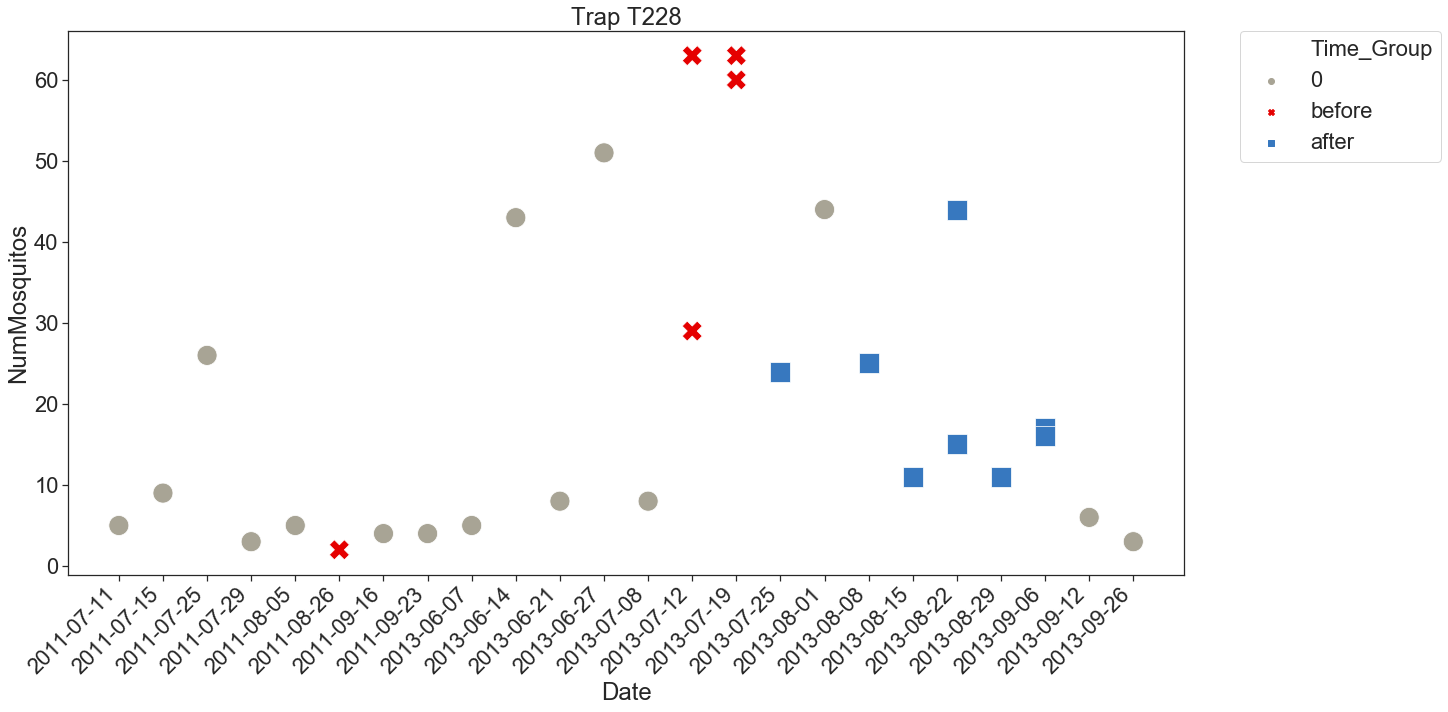

In [92]:
# Plot 228 Trap
sns.set(font_scale = 2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(20,10))
colors = ["greyish", "red", "windows blue"]
ax = sns.scatterplot(x="Date", y="NumMosquitos", style ="Time_Group", hue="Time_Group", s=400, sizes=(150, 500), palette=sns.xkcd_palette(colors), legend="full",data=df)
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Trap T228")

## Effectiveness of Mosquito Spray (Overview)

In [113]:
df

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,WnvPresent,Time_Group,Sprayed_Date,sprayed_displacement,sprayed_strength,NumMosquitos
0,2011-06-10,"1000 East 67th Street, Chicago, IL 60637, USA",10,E 67TH ST,T073,"1000 E 67TH ST, Chicago, IL",41.773215,-87.600880,8,0,0,0,0.0,0.0,4
1,2011-06-10,"1100 North Artesian Avenue, Chicago, IL 60622,...",11,S ARTESIAN AVE,T160,"1100 S ARTESIAN AVE, Chicago, IL",41.903002,-87.688267,8,0,0,0,0.0,0.0,1
2,2011-06-10,"1100 South California Avenue, Chicago, IL 6061...",11,S CALIFORNIA,T047,"1100 S CALIFORNIA, Chicago, IL",41.868142,-87.696269,9,0,0,0,0.0,0.0,35
3,2011-06-10,"1100 West Chicago Avenue, Chicago, IL 60642, USA",11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,0,0,0,0.0,0.0,1
4,2011-06-10,"1200 West Greenleaf Avenue, Chicago, IL 60626,...",12,W GREENLEAF AVE,T018,"1200 W GREENLEAF AVE, Chicago, IL",42.010412,-87.662140,8,0,0,0,0.0,0.0,7
5,2011-06-10,"1300 North Laramie Avenue, Chicago, IL 60651, USA",13,N LARAMIE AVE,T230,"1300 N LARAMIE AVE, Chicago, IL",41.904194,-87.756155,9,0,0,0,0.0,0.0,4
6,2011-06-10,"1700 North Ashland Avenue, Chicago, IL 60622, USA",17,N ASHLAND AVE,T232,"1700 N ASHLAND AVE, Chicago, IL",41.912563,-87.668055,9,0,0,0,0.0,0.0,11
7,2011-06-10,"1700 West 95th Street, Chicago, IL 60643, USA",17,W 95TH ST,T094,"1700 W 95TH ST, Chicago, IL",41.720848,-87.666014,9,0,0,0,0.0,0.0,1
8,2011-06-10,"2500 South Millard Avenue, Chicago, IL 60623, USA",25,S MILLARD AVE,T152,"2500 S MILLARD AVE, Chicago, IL",41.846075,-87.716277,9,0,0,0,0.0,0.0,1
9,2011-06-10,"3300 North Rutherford Avenue, Chicago, IL 6063...",33,N RUTHERFORD AVE,T144,"3300 N RUTHERFORD AVE, Chicago, IL",41.940160,-87.794896,9,0,0,0,0.0,0.0,3


/Users/applebelle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Text(0.5, 1.0, 'Effectiveness of Mosquito Sprays')

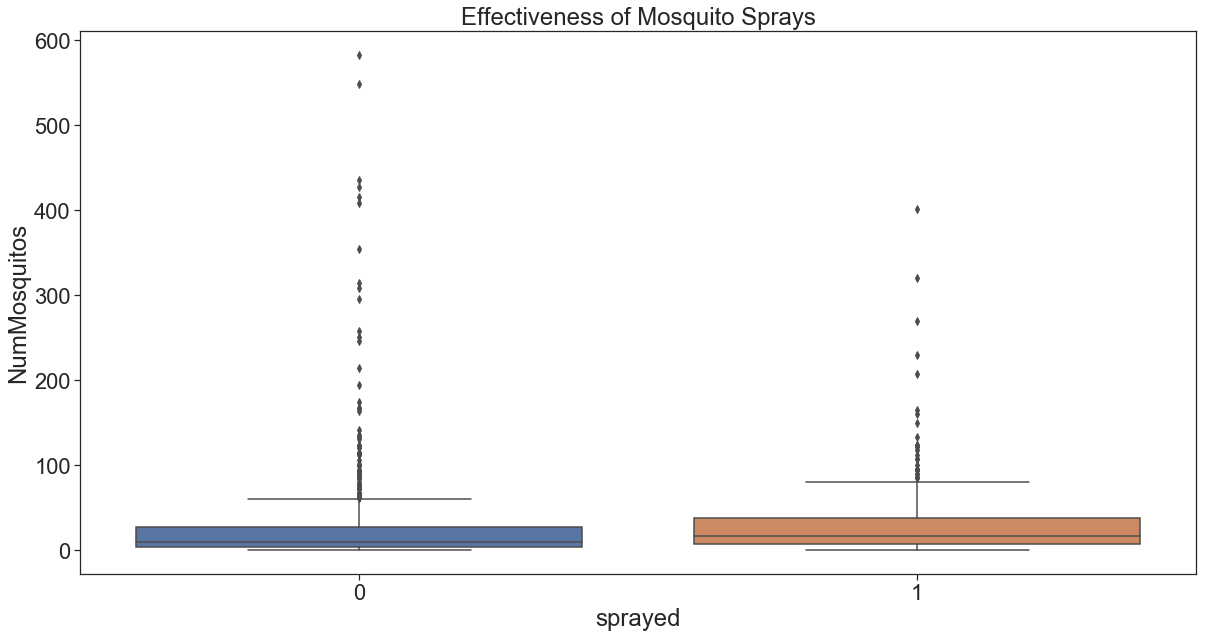

In [116]:
## Plot the boxplot for those measurements within 3km and 6 days from the time of spray vs the rest

# Convert sprayed_strength to
df2 = df[(df['Date'] > '2012-1-1 01:00:00')]
df2["sprayed"] = 0
for i, row1 in df2.iterrows():
    if df2.loc[i, "Time_Group"] == "after":
        if df2.loc[i, "sprayed_strength"] >= 0.25:
            df2.loc[i, "sprayed"] = 1
    else:
        df2.loc[i, "sprayed"] = 0
df2

# Plot using seaborn
df3 = df2[df2['Trap'].isin(traps)]
sns.set(font_scale = 2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x="sprayed", y="NumMosquitos", data=df3).set_title("Effectiveness of Mosquito Sprays")

## Perform Regression Test to Identify the Impact of Spraying

**Find Distances from the location to the weather stations**

Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level<br>
Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [43]:
len(train.Latitude)
coord1 = (41.995,-87.933)
coord = (train.Latitude[2],train.Longitude[2])
gp.distance(coord1, coord).km

24.16702401657992

In [48]:
import geopy.distance as gp

coord1 = (41.995,-87.933)  #coordinates for Chicago O'hare Airport (station 1)
coord2 = (41.786,-87.752)  #coordinates for Chicago Midway Airport (station 2)
dist_fr_1 = []
dist_fr_2 = []

for i in range(len(train.Latitude)):
    coord = (train.Latitude[i],train.Longitude[i])
    dist_fr_1.append(gp.distance(coord1, coord).km)
    dist_fr_2.append(gp.distance(coord2, coord).km)
train['dist_fr_1'] = dist_fr_1
train['dist_fr_2'] = dist_fr_2

### Repeat the preprocessing of the weather data in the same manner

In [57]:
weather = pd.read_csv('./Data/weather.csv')

In [58]:
#  Replace AvgSpeed, StnPressure and WetBulb reading with the mean measurements +/- 5 days
weather.iloc[[87, 1745, 2067], 21] = (7.48, 7.61, 6.37) # AvgSpeed
weather.iloc[[87, 848, 2410, 2411], 17] = (29.37, 29.09, 29.30, 29.30) # StnPressure
weather.iloc[[848, 2410, 2412, 2415], 7] = (71.89, 64.67, 64.67, 59.44) # WetBulb

In [59]:
# Calculate daylight length
def timediff(a,b):
    amin = int(a[:-2])*60 + int(a[-2:])
    bmin = int(b[:-2])*60 + int(b[-2:])
    return abs(amin-bmin)

daylen = []
for i in range(0,len(weather.Sunrise),2):
    diff = timediff(weather.Sunset[i],weather.Sunrise[i])
    daylen.append(diff)
    daylen.append(diff)
weather['daylen']=daylen

# Impute missing/categorical values for PrecipTotal
weather.PrecipTotal = weather.PrecipTotal.replace('  T',0.001)
weather.PrecipTotal = weather.PrecipTotal.replace('M',0)

# Imputes missing values for Tavg with the mean of the max/min for each day
for i in range(len(weather.Tavg)):
    if weather.Tavg[i]=='M':
        weather.Tavg[i]= round((weather.Tmax[i]+weather.Tmin[i])/2)
        
# Impute missing values for SeaLevel with the mean
for index, row in weather[weather['SeaLevel']=='M'].iterrows():
    weather.SeaLevel[index] = np.nanmean(pd.to_numeric(weather[weather['Date']==row['Date']]['SeaLevel'], 
                                                          errors='coerce'))

/Users/applebelle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/applebelle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
# Dummify CodeSum
cols = ["+FC", "FC", "TS", "GR", "RA","DZ","SN","SG","GS","PL","IC","FG+","FG","BR","UP","HZ","FU",
"VA","DU","DS","PO","SA","SS","PY","SQ","DR","SH","FZ","MI","PR","BC","BL","VC"]

for col in cols:
    weather[col] = 0
    
weather.CodeSum = weather.CodeSum.str.rsplit()
for i in weather[cols]:
    for index, word in weather.CodeSum.iteritems():
        for code in word:
            if code == i:
                weather.loc[index, i] = 1

In [61]:
# Drop unwanted columns
weather = weather.drop(['Depart','Heat','Cool','Depth','Water1','SnowFall','Sunrise','Sunset','CodeSum'],axis=1)
weather.Date = pd.to_datetime(weather.Date)
for col in ['Tavg','WetBulb','PrecipTotal','StnPressure','SeaLevel','AvgSpeed']:
    weather[col] = pd.to_numeric(weather[col])
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,daylen,+FC,FC,TS,GR,RA,DZ,SN,SG,GS,PL,IC,FG+,FG,BR,UP,HZ,FU,VA,DU,DS,PO,SA,SS,PY,SQ,DR,SH,FZ,MI,PR,BC,BL,VC
0,1,2007-05-01,83,50,67.0,51,56.0,0.0,29.10,29.82,1.7,27,9.2,841,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,2007-05-01,84,52,68.0,51,57.0,0.0,29.18,29.82,2.7,25,9.6,841,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2007-05-02,59,42,51.0,42,47.0,0.0,29.38,30.09,13.0,4,13.4,843,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,2007-05-02,60,43,52.0,42,47.0,0.0,29.44,30.08,13.3,2,13.4,843,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2007-05-03,66,46,56.0,40,48.0,0.0,29.39,30.12,11.7,7,11.9,845,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Combine Train and Weather Data

In [62]:
# Initiate new weather dataframe and join with train data

wdf = pd.DataFrame()
for i in range(len(train.Date)):
    dateweather = weather[weather.Date == train.Date[i]].drop(['Date','Station'],axis=1)
    weightedw = (dist_fr_2[i] * dateweather.iloc[0].astype(float) +
             dist_fr_1[i] * dateweather.iloc[1].astype(float))/(dist_fr_1[i] + dist_fr_2[i])
    wdf[i] = weightedw
wdf = wdf.T
finaltrain = train.join(wdf)


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,WnvPresent,NumMosquitos,Time_Group,Sprayed_Date,sprayed_displacement,sprayed_strength,sprayed,dist_fr_1,dist_fr_2,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,daylen,+FC,FC,TS,GR,RA,DZ,SN,SG,GS,PL,IC,FG+,FG,BR,UP,HZ,FU,VA,DU,DS,PO,SA,SS,PY,SQ,DR,SH,FZ,MI,PR,BC,BL,VC
0,2011-06-10,"1000 East 67th Street, Chicago, IL 60637, USA",CULEX RESTUANS,10,E 67TH ST,T073,"1000 E 67TH ST, Chicago, IL",41.773215,-87.600880,8,0,4,0,0,0.0,0.0,0,36.969222,12.643511,70.490312,51.000000,60.745156,56.0,57.745156,0.460388,29.247258,29.925097,6.176453,1.509688,7.627422,910.0,0.0,0.0,0.745156,0.0,0.254844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-06-10,"1100 North Artesian Avenue, Chicago, IL 60622,...",CULEX PIPIENS/RESTUANS,11,S ARTESIAN AVE,T160,"1100 S ARTESIAN AVE, Chicago, IL",41.903002,-87.688267,8,0,1,0,0,0.0,0.0,0,22.720061,14.032074,70.236394,51.000000,60.618197,56.0,57.618197,0.470544,29.240910,29.927636,6.214541,1.763606,7.690901,910.0,0.0,0.0,0.618197,0.0,0.381803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-06-10,"1100 South California Avenue, Chicago, IL 6061...",CULEX PIPIENS/RESTUANS,11,S CALIFORNIA,T047,"1100 S CALIFORNIA, Chicago, IL",41.868142,-87.696269,9,0,17,0,0,0.0,0.0,0,24.167024,10.231018,70.405140,51.000000,60.702570,56.0,57.702570,0.463794,29.245128,29.925949,6.189229,1.594860,7.648715,910.0,0.0,0.0,0.702570,0.0,0.297430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-06-10,"1100 South California Avenue, Chicago, IL 6061...",CULEX RESTUANS,11,S CALIFORNIA,T047,"1100 S CALIFORNIA, Chicago, IL",41.868142,-87.696269,9,0,16,0,0,0.0,0.0,0,24.167024,10.231018,70.405140,51.000000,60.702570,56.0,57.702570,0.463794,29.245128,29.925949,6.189229,1.594860,7.648715,910.0,0.0,0.0,0.702570,0.0,0.297430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-06-10,"1100 South California Avenue, Chicago, IL 6061...",CULEX TERRITANS,11,S CALIFORNIA,T047,"1100 S CALIFORNIA, Chicago, IL",41.868142,-87.696269,9,0,2,0,0,0.0,0.0,0,24.167024,10.231018,70.405140,51.000000,60.702570,56.0,57.702570,0.463794,29.245128,29.925949,6.189229,1.594860,7.648715,910.0,0.0,0.0,0.702570,0.0,0.297430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2011-06-10,"1200 West Greenleaf Avenue, Chicago, IL 60626,...",CULEX RESTUANS,12,W GREENLEAF AVE,T018,"1200 W GREENLEAF AVE, Chicago, IL",42.010412,-87.662140,8,0,5,0,0,0.0,0.0,0,22.505198,26.017229,69.927620,51.000000,60.463810,56.0,57.463810,0.482895,29.233191,29.930724,6.260857,2.072380,7.768095,910.0,0.0,0.0,0.463810,0.0,0.536190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2011-06-10,"1200 West Greenleaf Avenue, Chicago, IL 60626,...",CULEX SALINARIUS,12,W GREENLEAF AVE,T018,"1200 W GREENLEAF AVE, Chicago, IL",42.010412,-87.662140,8,0,1,0,0,0.0,0.0,0,22.505198,26.017229,69.927620,51.000000,60.463810,56.0,57.463810,0.482895,29.233191,29.930724,6.260857,2.072380,7.768095,910.0,0.0,0.0,0.463810,0.0,0.536190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2011-06-10,"1200 West Greenleaf Avenue, Chicago, IL 60626,...",CULEX TERRITANS,12,W GREENLEAF AVE,T018,"1200 W GREENLEAF AVE, Chicago, IL",42.010412,-87.662140,8,0,1,0,0,0.0,0.0,0,22.505198,26.017229,69.927620,51.000000,60.463810,56.0,57.463810,0.482895,29.233191,29.930724,6.260857,2.072380,7.768095,910.0,0.0,0.0,0.463810,0.0,0.536190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [137]:
cols = ['Species',
       'WnvPresent', 'NumMosquitos', 'sprayed_strength', 'sprayed', 'WetBulb',
       'PrecipTotal', 'SeaLevel', 'daylen']

final_train = finaltrain[cols]

In [138]:
final_train = pd.concat([final_train, pd.get_dummies(final_train["Species"])], axis=1).drop(columns="Species")

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [151]:
X = final_train.drop(["NumMosquitos"], axis=1)
y = final_train["NumMosquitos"]

In [152]:
Xs = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.25, random_state=42)
lr = LogisticRegression().fit(X_train,y_train)
lr.score(X_test,y_test)

/Users/applebelle/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/applebelle/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/applebelle/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/applebelle/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.16047548291233285

In [160]:
pd.DataFrame(lr.coef_, columns=X.columns)

,WnvPresent,sprayed_strength,sprayed,WetBulb,PrecipTotal,SeaLevel,daylen,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS
0,-0.529178,-0.103572,-0.089753,-0.252314,-0.079488,-0.360379,-0.293694,-0.089217,-0.027502,-0.205714,0.065938,0.178002,0.185195,0.437641
1,-0.577897,-0.079828,-0.198904,0.045621,0.015825,0.017917,-0.064063,-0.080945,0.044500,-0.052288,0.024360,0.008439,-0.098997,0.009742
2,-0.323657,-0.165950,0.007472,0.009253,0.066502,0.009026,-0.024209,-0.069753,-0.013952,0.098772,0.074509,-0.020764,-0.086853,-0.508094
3,-0.294502,-0.038947,0.086685,-0.310882,0.140805,-0.151823,0.062964,-0.057712,0.117464,0.002979,0.097863,-0.271601,-0.076720,-0.453710
4,-0.085363,-0.181160,0.119314,0.016693,-0.037663,-0.084067,-0.115592,-0.058166,0.073665,0.066985,0.048865,-0.241623,-0.067392,-0.419870
5,-0.149149,-0.161745,0.275326,0.144147,0.120523,0.081165,-0.026168,-0.055719,-0.031501,-0.010835,0.108241,-0.226285,-0.062509,-0.083910
6,-0.200304,-0.135678,0.116967,-0.055907,-0.066132,0.028612,-0.005481,0.179498,0.012866,0.096139,0.043231,-0.222115,-0.069888,-0.386795
7,-0.221988,0.065100,-0.045047,0.216113,0.112177,0.272090,-0.052092,-0.053280,0.020340,0.076698,0.035207,-0.170476,-0.057631,-0.314415
8,0.120305,-0.113880,0.002141,0.003436,-0.061372,0.115672,0.036625,-0.049610,0.083781,0.072816,-0.001859,-0.189269,-0.061424,-0.333463
9,-0.269520,-0.066474,0.174860,0.252580,-0.130247,0.015702,-0.109617,-0.044056,-0.101730,0.032845,0.166636,-0.154750,-0.035499,-0.290212


## Statistical Inference

In [65]:
# Pr (WNV) 
sum(train["WnvPresent"] == 1) / len(train["WnvPresent"])

0.07615156017830609

In [66]:
#Pr (WNV | Spray)
spray_df = train[train["Time_Group"] == "after"]

sum(spray_df["WnvPresent"] == 1) / len(spray_df["WnvPresent"])

0.17008797653958943